In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

# Styling
plt.rcParams['axes.formatter.useoffset'] = False
plt.style.use('ggplot')

# Inle Lake data exploration (part 2)

Follow-up exploration of the Inle Lake dataset. See e-mails from Marit received 15.02.2019 at 15.29 and 28.02.2019 at 11.00 for details.

In [2]:
# Data source
in_xlsx = r'../data/inle_data_jes_tidied.xlsx'

## 1. Macrophytes

Marit's e-mail from 28.02.2019 at 11.00 includes the attachment *dekning.xlsx*, which has some suggestions for ways to analyse and display the macrophyte data. In *Sheet3* of the Excel workbook, Marit suggests grouping the macrophytes into four "life form" categories and producing boxplots showing changes through time. Ideally, we'd also like some indication of whether differences in abundance between time periods are statistically significant. 

Grouping the data in this way gives one data point per site per time period, which equates to between 6 and 16 points per "box" (only 6 sites were sampled in March 2017; for other time periods between 15 and 16 sites were investigated). This is not really enough to robustly derive statistical distributions for significance testing. However, as a guide, I will use "bootstrapping" to generate [notched boxplots](https://sites.google.com/site/davidsstatistics/home/notched-box-plots), where notches illustrate approximate **95% confidence intervals about the median**. As a rough indicator, differences between groups are "significant" when the notched regions *do not* overlap. 

In [3]:
# Read data
mac_df = pd.read_excel(in_xlsx, sheet_name='macro_transposed')

# n_taxa not needed here
del mac_df['n_taxa']

# Assume if not stated then abundance = 0
mac_df.fillna(0, inplace=True)

# Set -1 to NaN
mac_df[mac_df==-1] = np.nan

# Cube semi-quant cols
for col in mac_df.columns:
    if col not in ['site', 'date']:
        mac_df[col] = mac_df[col]**3
        
# Aggregate by life form
mac_agg_dict = {'submerged':      ['Ceratophyllum demersum', 'Hydrilla verticillata', 
                                   'Myriophyllum cf spicatum', 'Myriophyllum verticillatum', 
                                   'Najas indica', 'Nechamandra alternifolia',
                                   'Potamogeton crispus', 'Potamogeton lucens', 
                                   'Potamogeton lucens-hybrid', 'Potamogeton cf nodosus', 
                                   'Potamogeton cf wrightii', 'Stuckenia pectinata',
                                   'Stuckenia pectinata-hybrid', 'Utricularis cf aurea', 
                                   'Utricularia cf australis'],                
                'free-floating':   ['Eichornia crassipes', 'Lemna trisulca', 
                                    'Pistia stratiotes', 'Spirodela polyrhizza', 
                                    'Salvinia cucullata'],                
                'floating-leaved': ['Nelumbo nucifera', 'Nymphaea nouchali', 
                                    'Nymphaea pubescens', 'Nymphaea sp', 
                                    'Nymphoides cf hydrophylla', 'Nymphoides indica',
                                    'Ottelia alismoides'],                
                'charophytes':     ['Chara cf. zeylanica']}

for key in mac_agg_dict.keys():
    mac_df[key] = mac_df[mac_agg_dict[key]].sum(axis=1)

# Get just aggregated groups    
mac_df = mac_df[['site', 'date'] + list(mac_agg_dict.keys())]

# Melt to long format
mac_df = mac_df.melt(id_vars=['site', 'date'],
                     var_name='life_form')

# Get period labels from dates
mac_df['period'] = mac_df['date'].dt.strftime('%Y-%m')

# Extract transect info
mac_df['transect'] = mac_df['site'].str[0]

# Extract site number info
mac_df['site_num'] = mac_df['site'].str[-1]

mac_df.head()

,site,date,life_form,value,period,transect,site_num
0,A1,2014-11-01,submerged,181.0,2014-11,A,1
1,A1,2015-02-01,submerged,217.0,2015-02,A,1
2,A1,2015-11-01,submerged,207.0,2015-11,A,1
3,A1,2017-03-01,submerged,189.0,2017-03,A,1
4,A2,2014-11-01,submerged,133.0,2014-11,A,2


### 1.1. Boxplots for each date, split by life form

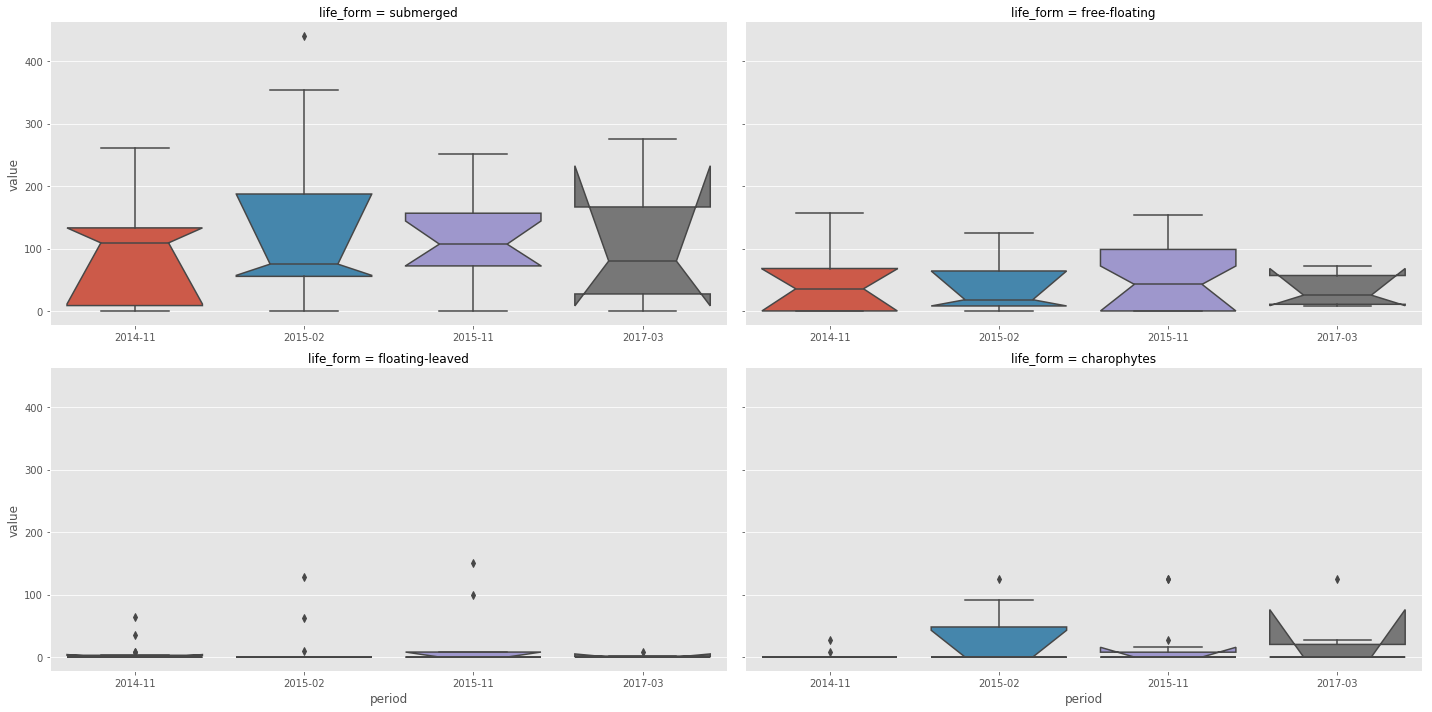

In [4]:
# Boxplots
g = sn.catplot(x='period', 
               y='value', 
               col='life_form',
               col_wrap=2,
               data=mac_df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=2)

Unfortunately, there is too little data to say anything meaningful about the distributions of "floating-leaved" or "charophyte" life forms. Abundances of "submerged" and "free-floating" macrophytes are higher, and there is a clear - but weak - seasonality for both groups: November median abundances are consistently higher than those in February, but the differences are not statistically significant given the available data (i.e. the notched intervals overlap between periods for each group).

Just for completeness, here are a few alternative visualisations of the same dataset.

### 1.2. Boxplots for each life form, split by date

The left column shows the two November samplings, and the right shows the spring (February and March).

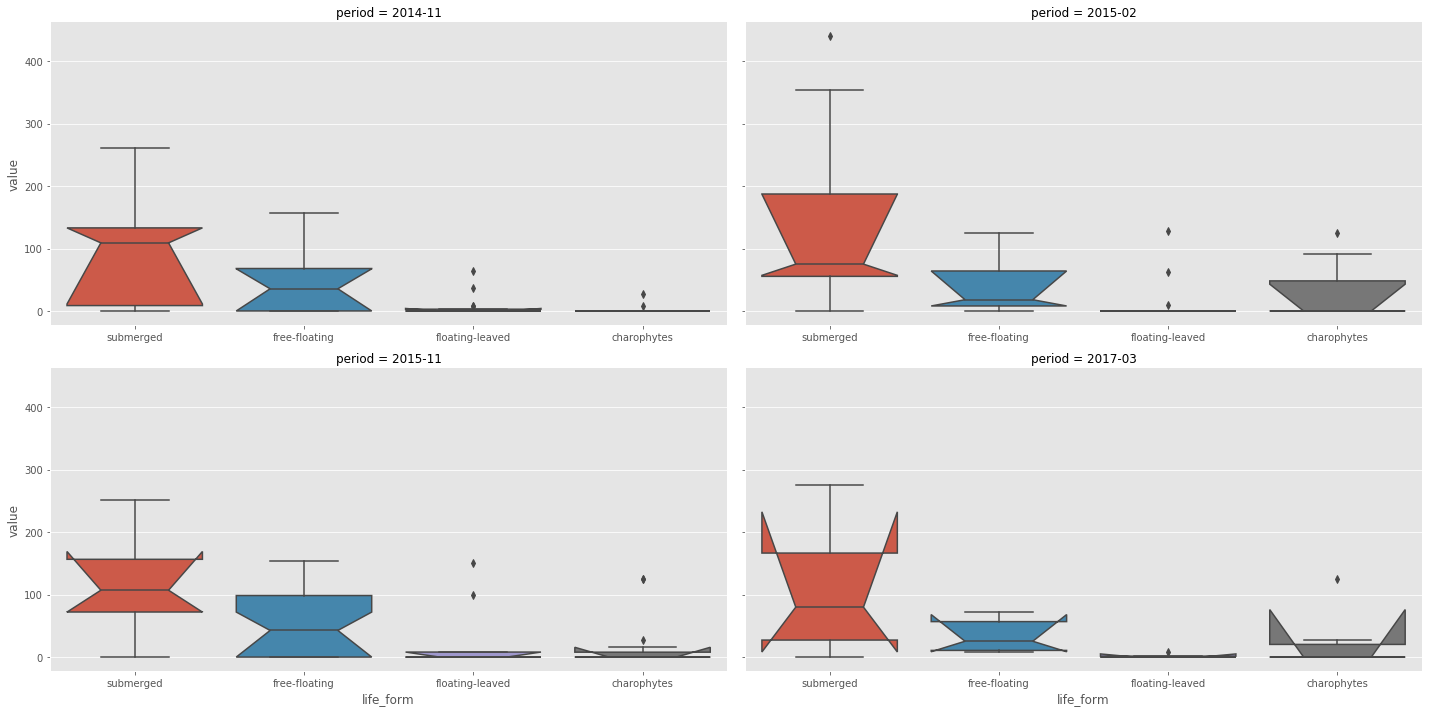

In [5]:
# Boxplots
g = sn.catplot(x='life_form', 
               y='value', 
               col='period',
               col_wrap=2,
               data=mac_df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=2)

### 1.3. Boxplots for each transect, split by life form

The plots below illustrate the variation in different life forms between transects (regardless of date).

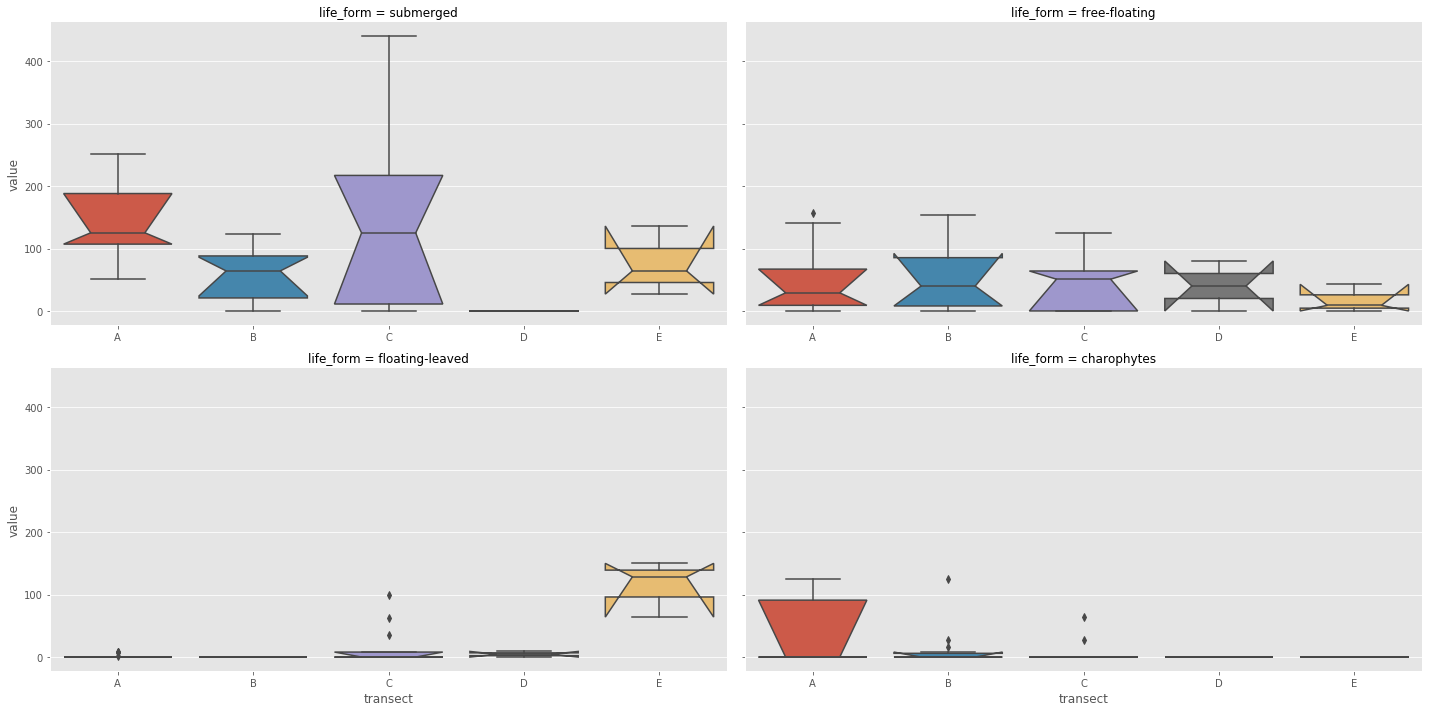

In [6]:
# Boxplots
g = sn.catplot(x='transect', 
               y='value', 
               col='life_form',
               col_wrap=2,
               data=mac_df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=2)

### 1.4. Bar plots by site and transect

In the sheet *abundance-transekt-figurer* of *dekning.xlsx*, Marit has created bar plots showing life form abundances through time for each site and transect. These are recreated in the code below, where columns correspond to site numbers (1 to 5) and rows correspond to transects (A to C). Transects D and E have been omitted due to lack of data.

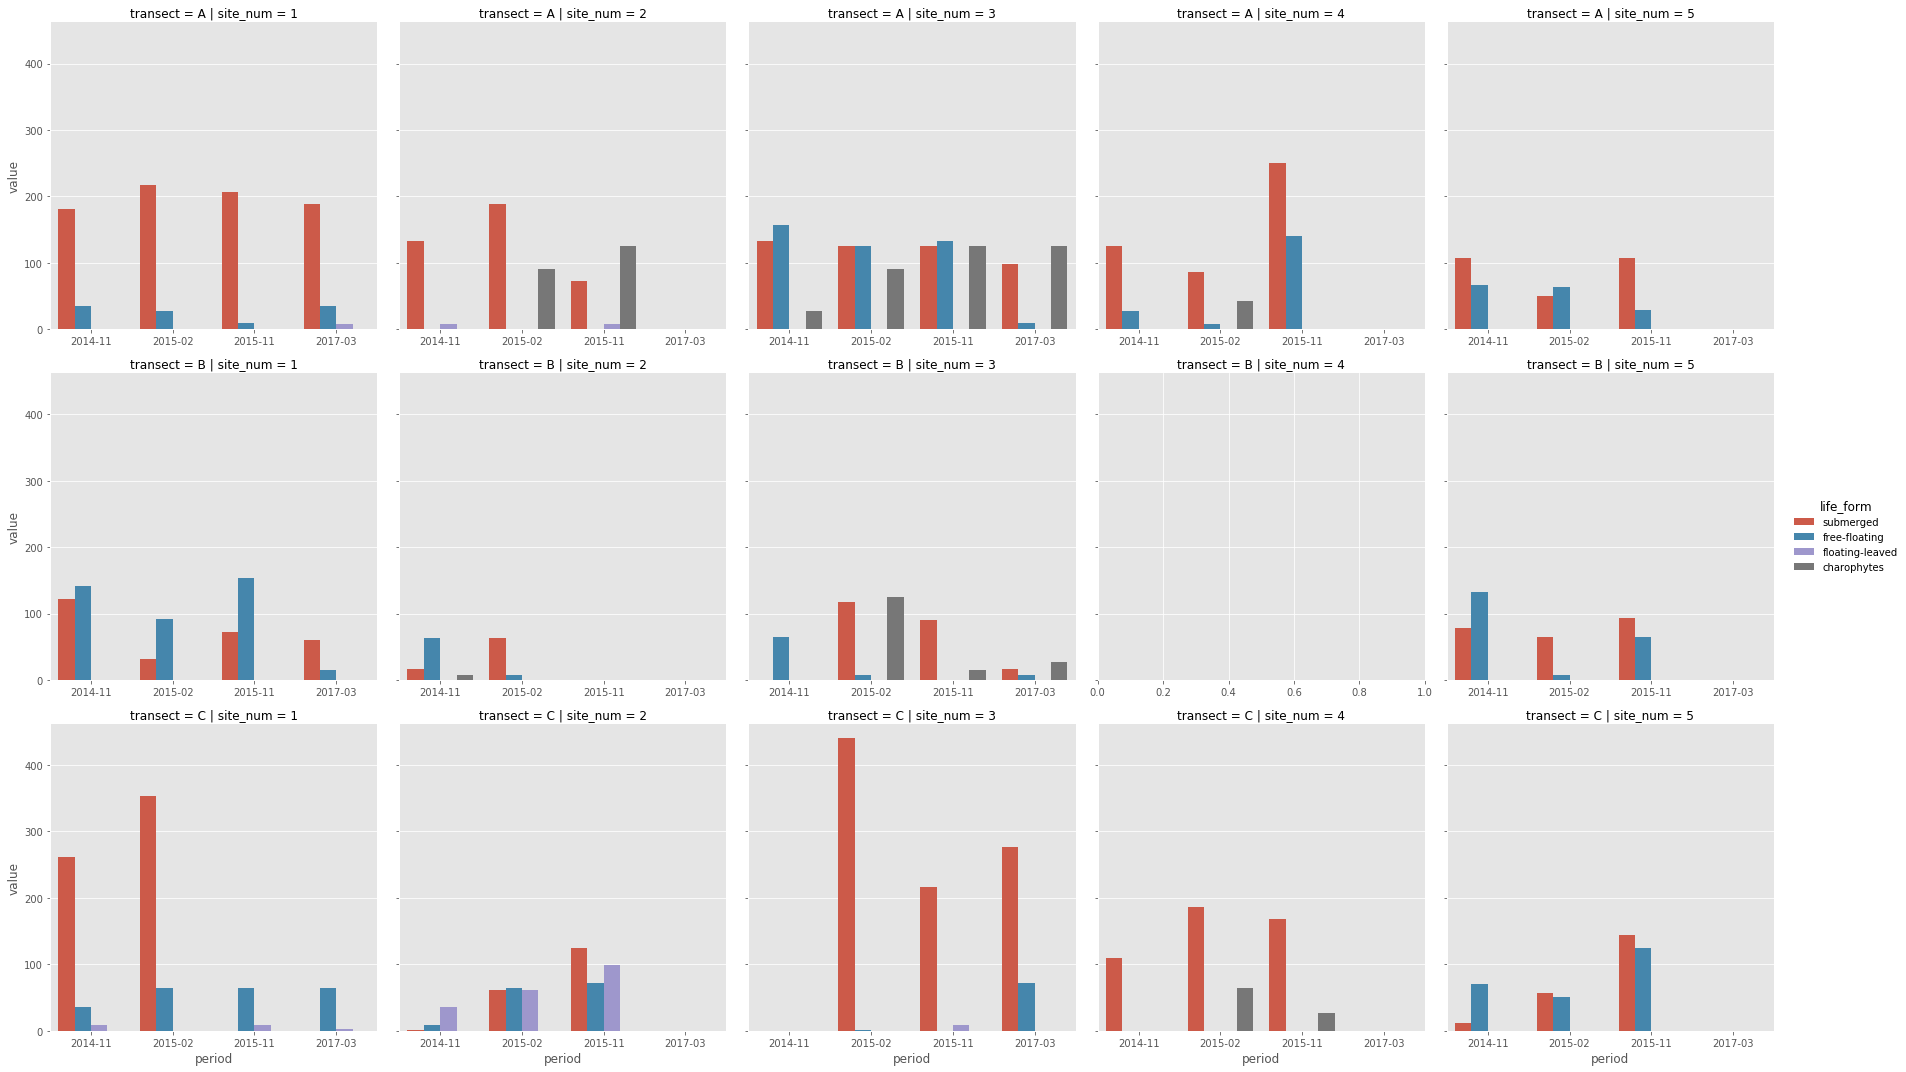

In [7]:
# Just sites 1 to 5 on transects A to C
mac_df = mac_df.query("(site_num in ('1', '2', '3', '4', '5')) and "
                      "(transect in ('A', 'B', 'C'))")

# Barplots
g = sn.catplot(x='period', 
               y='value', 
               row='transect',
               col='site_num',
               hue='life_form',
               data=mac_df, 
               kind='bar',
               sharex=False,
               sharey=True,
               aspect=1)

### 1.5. Species level groupings

*Sheet4* of Marit's spreadsheet considers abundances for individual species, with the species within each "life form" grouped into separate charts. Marit's 3D line line charts plot the **mean** abundance for each species, but to consider differences statistically we need to look at whole distributions. This can't be done in 3D, because the distributions overlap, but we can produce box plots for each species and create separate figures for each life form group.

In [8]:
def assign_life_form(row):
    """ Reclassify by life form. 
    """
    # Groupings mapping species to life form
    submerged = ['Ceratophyllum demersum', 'Hydrilla verticillata', 
                 'Myriophyllum cf spicatum', 'Myriophyllum verticillatum', 
                 'Najas indica', 'Nechamandra alternifolia',
                 'Potamogeton crispus', 'Potamogeton lucens', 
                 'Potamogeton lucens-hybrid', 'Potamogeton cf nodosus', 
                 'Potamogeton cf wrightii', 'Stuckenia pectinata',
                 'Stuckenia pectinata-hybrid', 'Utricularis cf aurea', 
                 'Utricularia cf australis']
    
    free_float = ['Eichornia crassipes', 'Lemna trisulca', 
                  'Pistia stratiotes', 'Spirodela polyrhizza', 
                  'Salvinia cucullata']
    
    float_leav = ['Nelumbo nucifera', 'Nymphaea nouchali', 
                 'Nymphaea pubescens', 'Nymphaea sp', 
                 'Nymphoides cf hydrophylla', 'Nymphoides indica',
                 'Ottelia alismoides']
    
    charo = ['Chara cf. zeylanica']
    
    # Assign group
    if row['species'] in submerged:
        return 'submerged'
    elif row['species'] in free_float:
        return'free-floating'
    elif row['species'] in float_leav:
        return 'floating-leaved'
    elif row['species'] in charo:
        return 'charophytes'
    else:
        return 'unknown'    

In [9]:
# Read data
mac_df = pd.read_excel(in_xlsx, sheet_name='macro_transposed')

# Assume if not stated then abundance = 0
mac_df.fillna(0, inplace=True)

# Set -1 to NaN
mac_df[mac_df==-1] = np.nan

del mac_df['n_taxa']

# Cube semi-quant cols
for col in mac_df.columns:
    if col not in ['site', 'date']:
        mac_df[col] = mac_df[col]**3   

# Melt to long format
mac_df = mac_df.melt(id_vars=['site', 'date'],
                     var_name='species')

# Get period labels from dates
mac_df['period'] = mac_df['date'].dt.strftime('%Y-%m')

# Extract transect info
mac_df['transect'] = mac_df['site'].str[0]

# Classify by life form
mac_df['life_form'] = mac_df.apply(assign_life_form, axis=1)

mac_df.head()

,site,date,species,value,period,transect,life_form
0,A1,2014-11-01,Ceratophyllum demersum,8.0,2014-11,A,submerged
1,A1,2015-02-01,Ceratophyllum demersum,0.0,2015-02,A,submerged
2,A1,2015-11-01,Ceratophyllum demersum,8.0,2015-11,A,submerged
3,A1,2017-03-01,Ceratophyllum demersum,64.0,2017-03,A,submerged
4,A2,2014-11-01,Ceratophyllum demersum,0.0,2014-11,A,submerged


#### 1.5.1. Life form = 'submerged'

The notched boxplots below show the results for each species. The overlaid line plots show the **mean** value for each species, which is comparable to what Marit has plotted in the Excel spreadsheet.

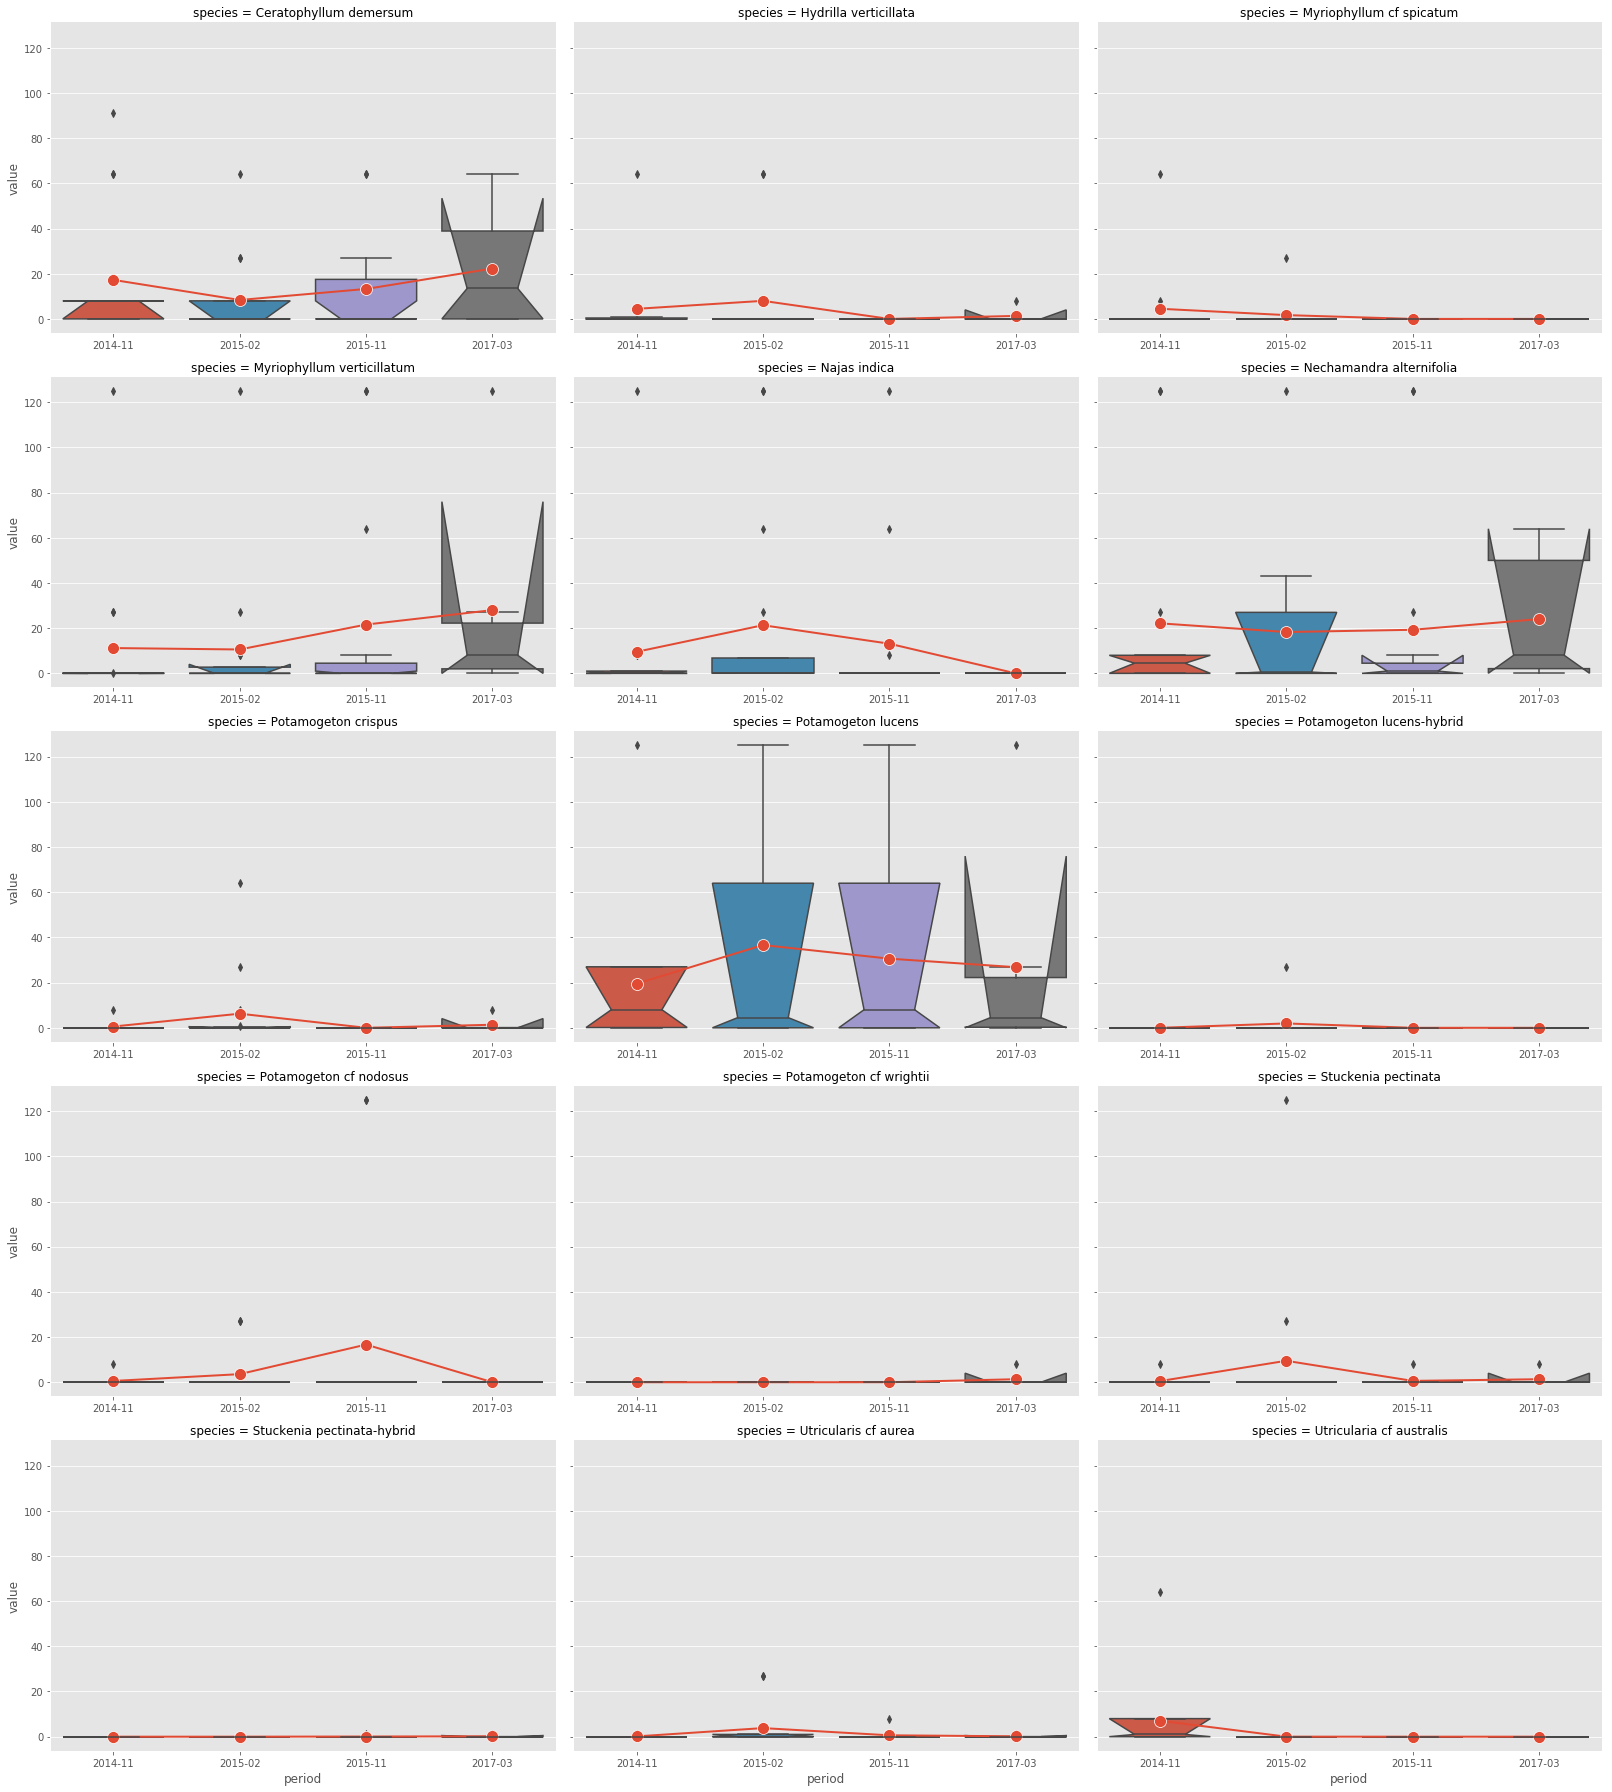

In [10]:
# Get life form of interest
df = mac_df.query('life_form == "submerged"')

# Boxplots
g = sn.catplot(x='period', 
               y='value', 
               col='species',
               col_wrap=3,
               data=df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=1.5)

# Add lines showing mean
g.map(sn.lineplot, 
      'period', 
      'value',
      ci=None,
      marker='o', 
      ms=12, 
      lw=2)

#### 1.5.2. Life form = 'free-floating'

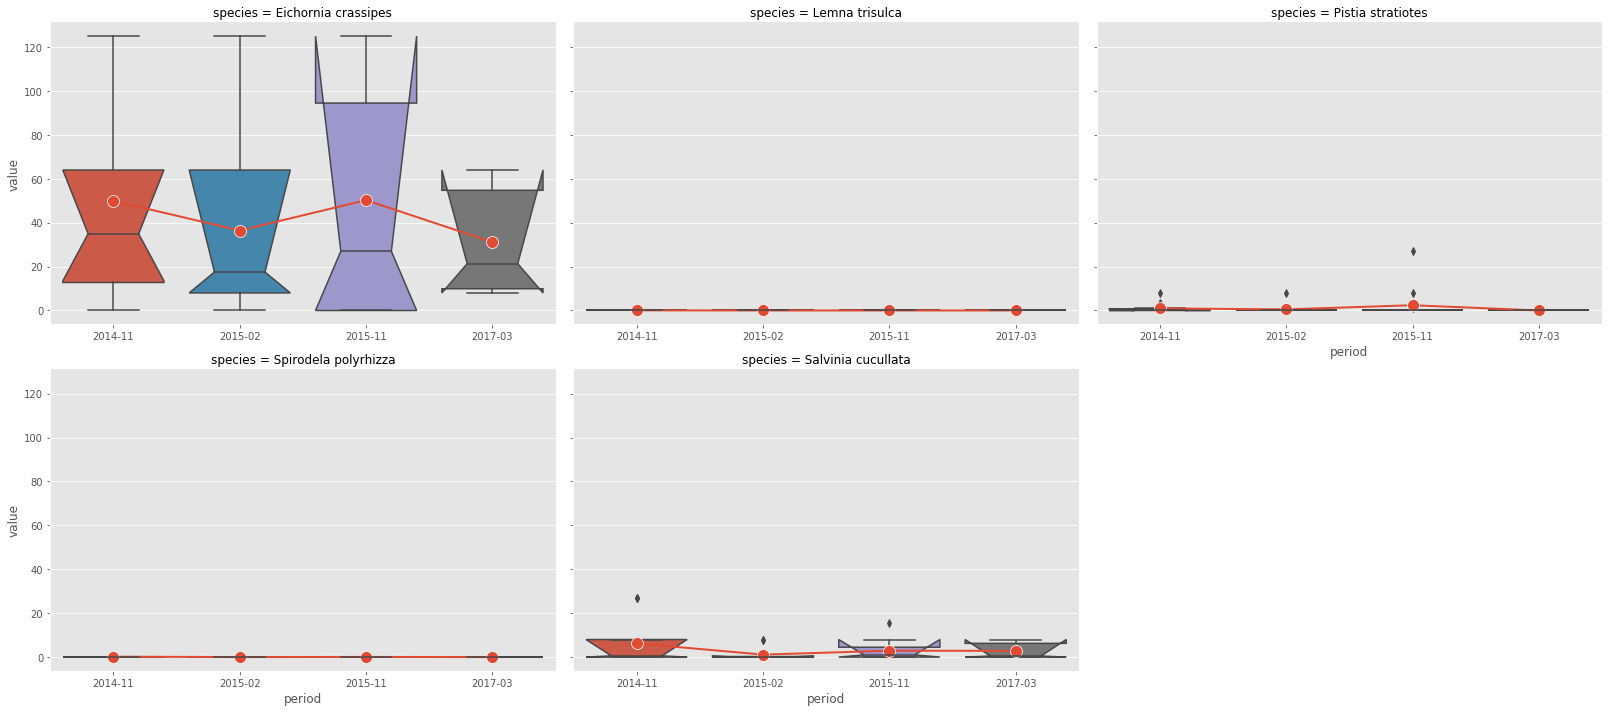

In [11]:
# Get life form of interest
df = mac_df.query('life_form == "free-floating"')

# Boxplots
g = sn.catplot(x='period', 
               y='value', 
               col='species',
               col_wrap=3,
               data=df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=1.5)

# Add lines showing mean
g.map(sn.lineplot, 
      'period', 
      'value',
      ci=None,
      marker='o', 
      ms=12, 
      lw=2)

#### 1.5.3. Life form = 'floating-leaved'

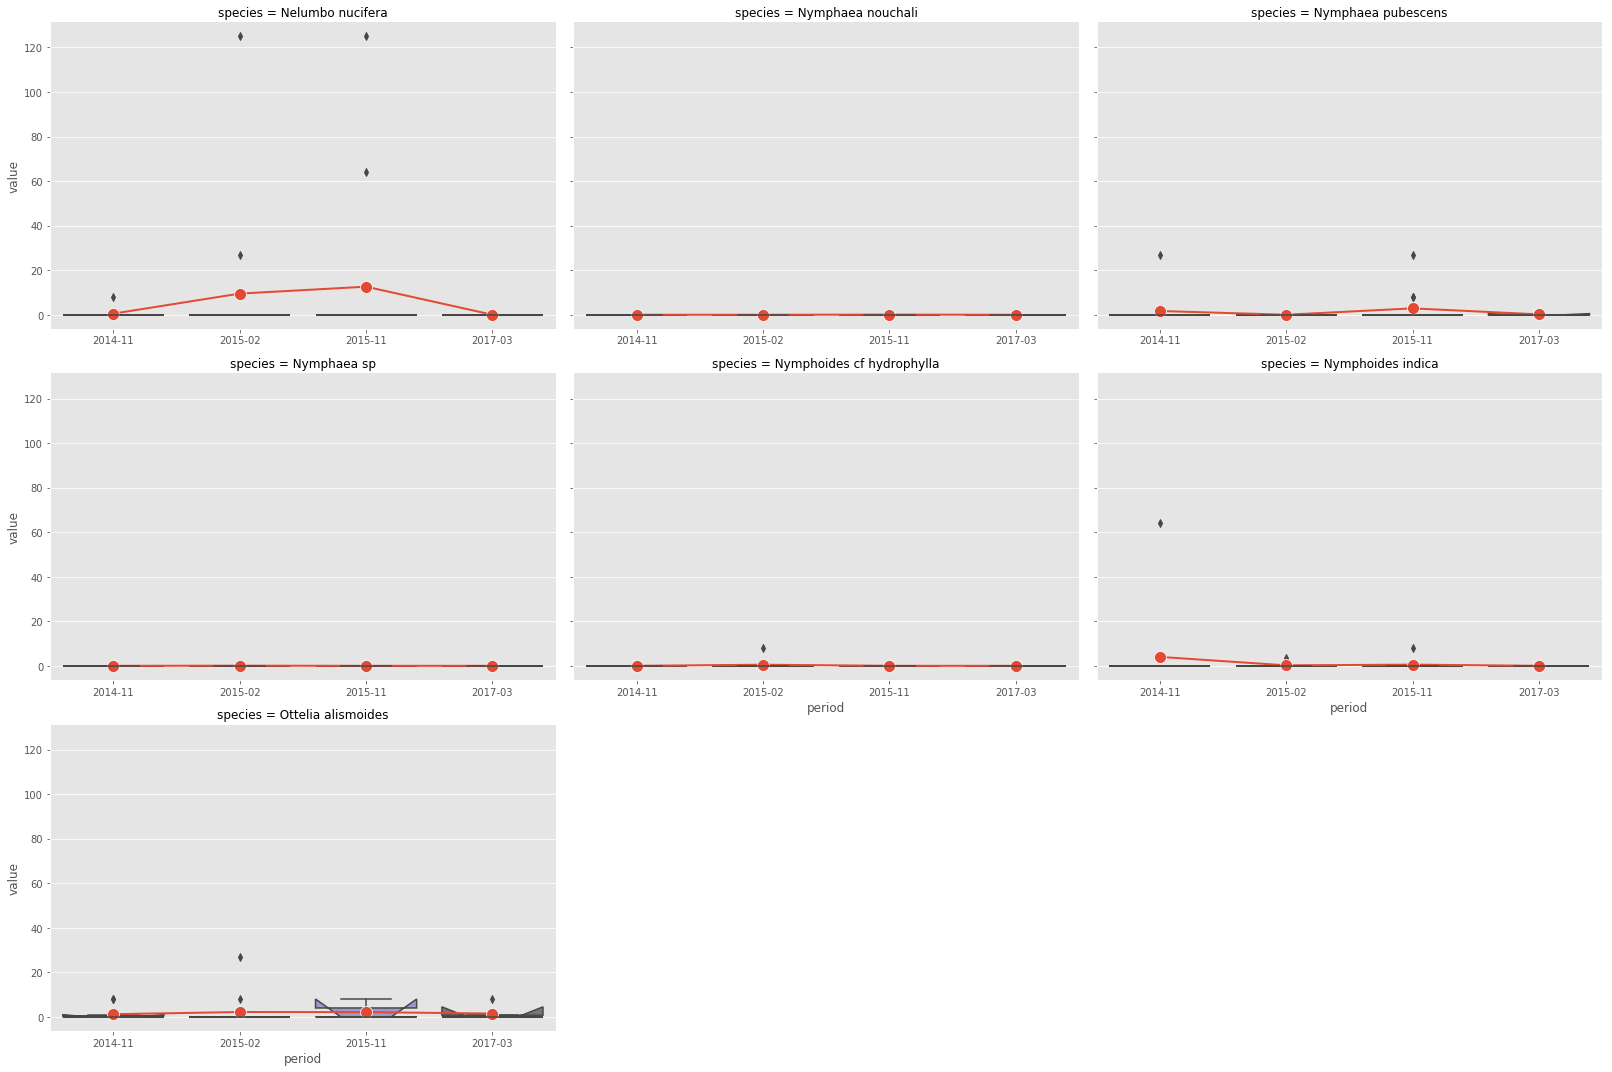

In [12]:
# Get life form of interest
df = mac_df.query('life_form == "floating-leaved"')

# Boxplots
g = sn.catplot(x='period', 
               y='value', 
               col='species',
               col_wrap=3,
               data=df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=1.5)

# Add lines showing mean
g.map(sn.lineplot, 
      'period', 
      'value',
      ci=None,
      marker='o', 
      ms=12, 
      lw=2)

#### 1.5.4. Life form = 'charophytes'

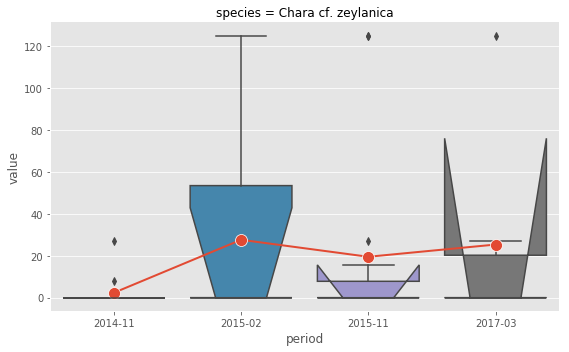

In [13]:
# Get life form of interest
df = mac_df.query('life_form == "charophytes"')

# Boxplots
g = sn.catplot(x='period', 
               y='value', 
               col='species',
               col_wrap=3,
               data=df, 
               kind='box',
               notch=True,
               bootstrap=10000,
               sharex=False,
               sharey=True,
               aspect=1.5)

# Add lines showing mean
g.map(sn.lineplot, 
      'period', 
      'value',
      ci=None,
      marker='o', 
      ms=12, 
      lw=2)

It's worth noting that, in general, **notched boxplots are not supposed to look like the ones above**. Most of the plots so far look more like a game of Space Invaders than a statistical analysis! This is due to the high data variability and a relatively small number of data points per box, leading to very wide confidence intervals (and boxplots that look more like spaceships/funncy little people than anything statistically meaningful). There's not a lot we can do about this, except conclude that macrophyte abundances at Inle are highly variable in both space and time. The main impression from the plots above is to note that macrophyte abundances are dominated by just a few common species:

 * **Submerged** life forms are predominantly *Ceratophyllum demersum*, *Myriophyllum verticillatum*, *Nechamandra alternifolia* and *Potamogeton lucens*

 * **Free-floating** life forms are dominated by *Eichornia crassipes*

 * **Floating-leaved** life forms are generally scarce, except in a few unusual locations (sites C2 and E1), where *Nelumbo nucifera* is common
 
 * The only **charophytes** species is *Chara cf. zeylanica*

## 2. Phytoplankton

### 2.1. Bar plots by site and transect

Marit's e-mail from 28.02.2019 at 11.00 includes a file named *Copy of Inle-macrophytes-phytoplankton James.xlsx*. The *phytoplankton biomass* worksheet of this file includes barplots for "total biomass" and "cyanobacteria" that are similar to those for macrophytes from section 1.4, above. The plots are recreated in the code below.

In [14]:
# Read data
phy_df = pd.read_excel(in_xlsx, sheet_name='phyto_transposed')

# Melt to long format
phy_df = phy_df.melt(id_vars=['site', 'date']).dropna(subset=['value'])

# Get period labels from dates
phy_df['period'] = phy_df['date'].dt.strftime('%Y-%m')

# Extract transect info
phy_df['transect'] = phy_df['site'].str[0]

# Extract site number info
phy_df['site_num'] = phy_df['site'].str[-1]

phy_df.head()

,site,date,variable,value,period,transect,site_num
0,A1,2015-02-25,Bacillariophyceae,0.224800,2015-02,A,1
1,A1,2015-11-22,Bacillariophyceae,0.198804,2015-11,A,1
2,A2,2015-02-25,Bacillariophyceae,0.012510,2015-02,A,2
3,A2,2015-11-22,Bacillariophyceae,0.194580,2015-11,A,2
4,A3,2014-11-05,Bacillariophyceae,0.074280,2014-11,A,3


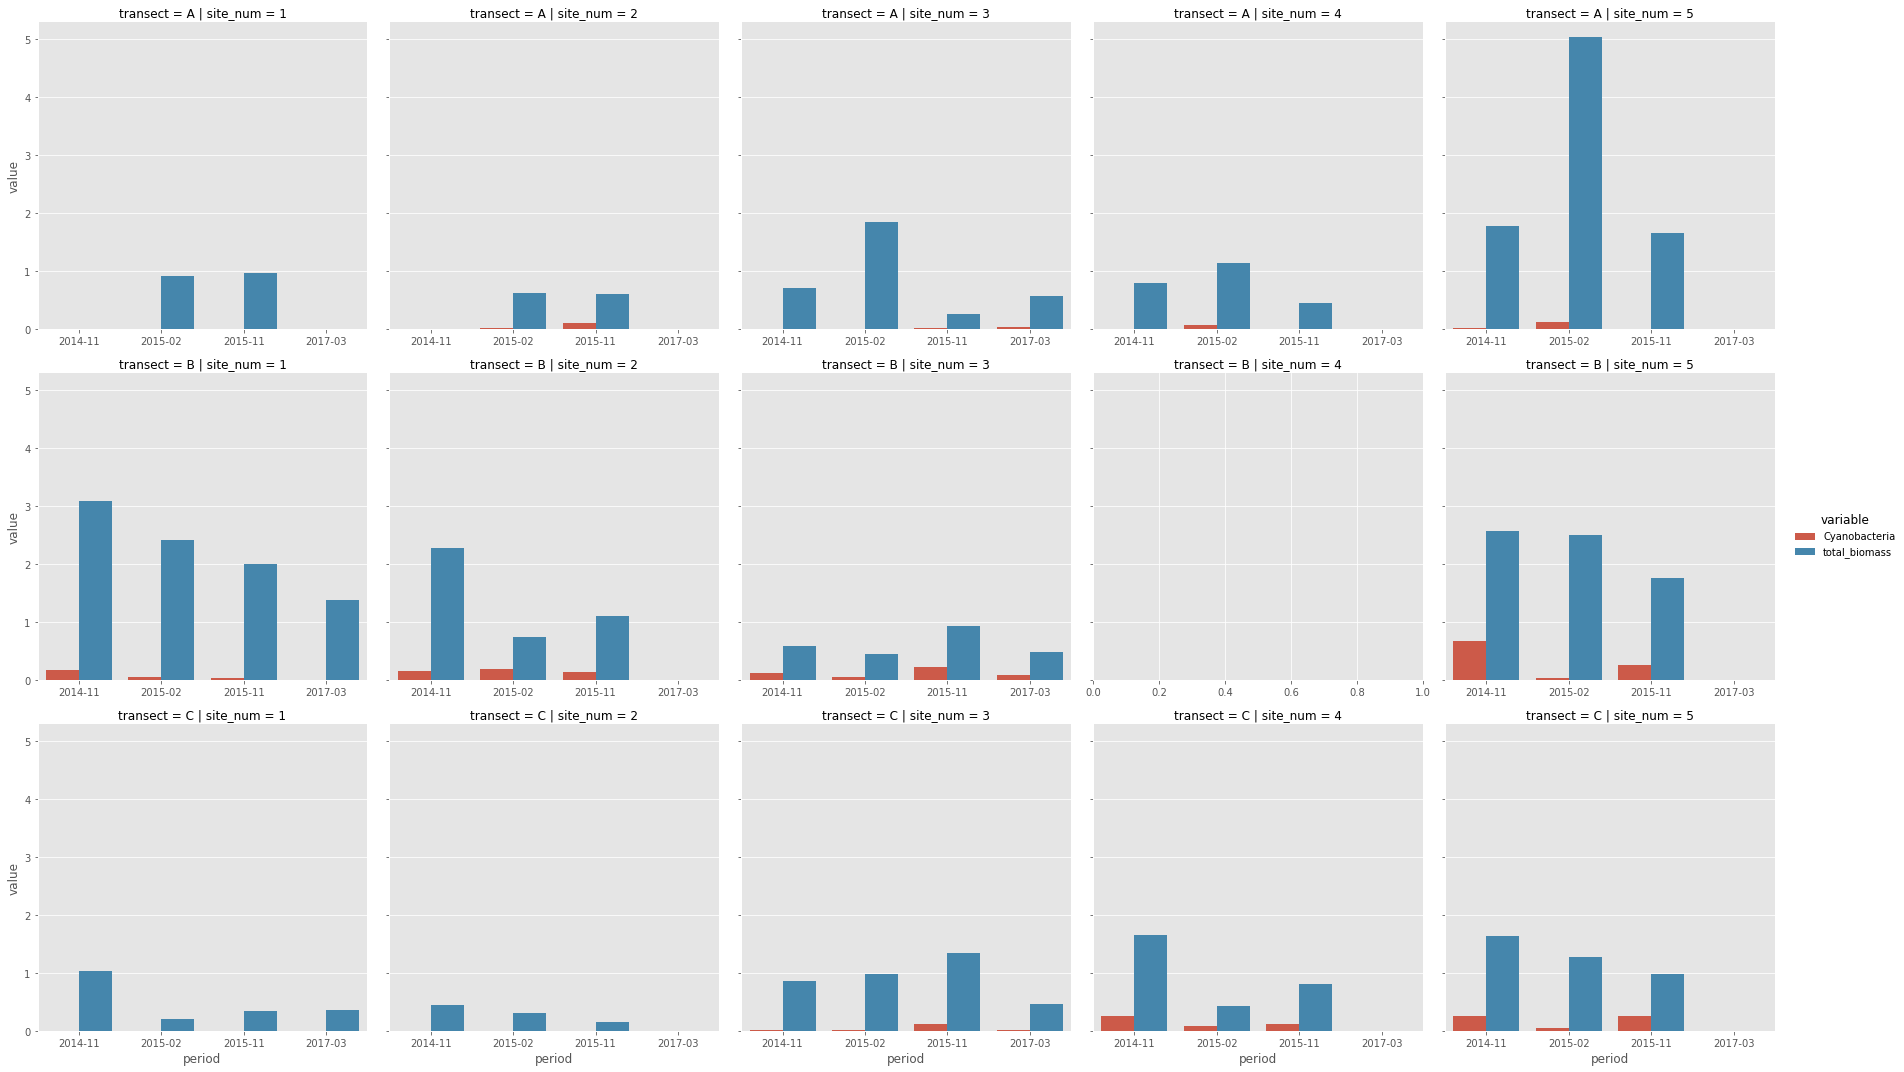

In [15]:
# Just sites 1 to 5 on transects A to C for total biomass and cyano
phy_df = phy_df.query("(site_num in ('1', '2', '3', '4', '5')) and "
                      "(transect in ('A', 'B', 'C')) and "
                      "variable in ('total_biomass', 'Cyanobacteria')")

# Barplots
g = sn.catplot(x='period', 
               y='value', 
               row='transect',
               col='site_num',
               hue='variable',
               data=phy_df, 
               kind='bar',
               sharex=False,
               sharey=True,
               aspect=1,
               order=['2014-11', '2015-02', '2015-11', '2017-03'])

### 2.2. Relationships between phytoplankton and macrophytes

I can now check for relationships between aggregated (i.e. life-form-level) macrophytes and the pyhtoplankton data. The plots below focus on "total biomass" and "cyanobacteria" for phytoplankton, as in Marit's spreadsheet.

In [16]:
# Read data
mac_df = pd.read_excel(in_xlsx, sheet_name='macro_transposed')

# n_taxa not needed here
del mac_df['n_taxa']

# Set -1 to NaN
mac_df[mac_df==-1] = np.nan

# Cube semi-quant cols
for col in mac_df.columns:
    if col not in ['site', 'date']:
        mac_df[col] = mac_df[col]**3
        
# Aggregate by life form
for key in mac_agg_dict.keys():
    mac_df[key] = mac_df[mac_agg_dict[key]].sum(axis=1)

# Get just aggregated groups    
mac_df = mac_df[['site', 'date'] + list(mac_agg_dict.keys())]

# Get period labels from dates
mac_df['period'] = mac_df['date'].dt.strftime('%Y-%m')
del mac_df['date']

mac_df.head()

,site,submerged,free-floating,floating-leaved,charophytes,period
0,A1,181.0,35.0,0.0,0.0,2014-11
1,A1,217.0,27.0,0.0,0.0,2015-02
2,A1,207.0,9.0,0.0,0.0,2015-11
3,A1,189.0,35.0,8.0,0.0,2017-03
4,A2,133.0,0.0,8.0,0.0,2014-11


In [17]:
# Read data
phy_df = pd.read_excel(in_xlsx, sheet_name='phyto_transposed')

# Get just total and cyano
phy_df = phy_df[['site', 'date', 'Cyanobacteria', 'total_biomass']]

# Get period labels from dates
phy_df['period'] = phy_df['date'].dt.strftime('%Y-%m')
del phy_df['date']

phy_df.head()

,site,Cyanobacteria,total_biomass,period
0,A1,0.010500,0.912400,2015-02
1,A1,0.014019,0.972545,2015-11
2,A2,0.023380,0.629950,2015-02
3,A2,0.105400,0.603720,2015-11
4,A3,0.007575,0.719587,2014-11


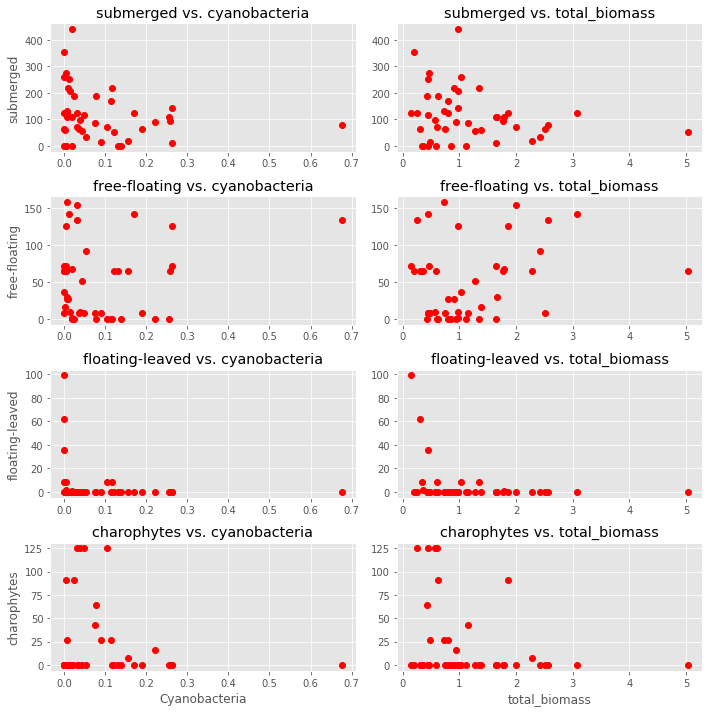

In [18]:
# Join
df = pd.merge(mac_df, phy_df, how='inner', on=['site', 'period'])

# Scatter matrix. Phyto in cols, macro in rows
# Get rows and cols for plotting
y_cols = [i for i in mac_df.columns if i not in ['site', 'period']]
x_cols = [i for i in phy_df.columns if i not in ['site', 'period']]
   
# Setup plot
fig, axes = plt.subplots(nrows=len(y_cols),
                         ncols=len(x_cols),
                         sharex=False,
                         sharey=False,
                         figsize=(10,10))

# Loop over data
for row, y_col in enumerate(y_cols):
    for col, x_col in enumerate(x_cols):
        # Plot
        axes[row, col].plot(df[x_col], df[y_col], 'ro')
        axes[row, col].set_title('%s vs. %s' % (y_col, x_col.lower()))
        if row == (len(y_cols) - 1):
            axes[row, col].set_xlabel(x_col)
        if col == 0:
            axes[row, col].set_ylabel(y_col.replace(' ', '\n'))
plt.tight_layout()

Unfortunately, there's not much to see here, except perhaps weak evidence for a positive relationship between total phytoplankton biomass and free-floating macrophyte abundance.